# What is Semantic Segmentation?
Semantic segmentation refers to the process of linking each pixel in an image to a class label. These labels could include a person, car, flower, piece of furniture, etc., just to mention a few.
We can think of semantic segmentation as image classification at a pixel level. For example, in an image that has many cars, segmentation will label all the objects as car objects. However, a separate class of models known as instance segmentation is able to label the separate instances where an object appears in an image. This kind of segmentation can be very useful in applications that are used to count the number of objects, such as counting the amount of foot traffic in a mall.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


# Please upvote the kernel if you found it insightful!

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install --upgrade pip
# !pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
# import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/NYU13/image/images/'
MASK_PATH = '/content/drive/MyDrive/NYU13/seg13/masks/'

In [ ]:
n_classes = 14

def create_df(IMAGE_PATH):
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))



In [ ]:
df = create_df(IMAGE_PATH)
print('Total Images: ', len(df))


Total Images:  1449


In [ ]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  1108
Val Size     :  196
Test Size    :  145


In [ ]:
def deformat_mask(mask):
    mask[mask==255]=13
    return mask

In [ ]:
import os
import cv2

# Đường dẫn đến thư mục chứa ảnh
image_dir = '/content/drive/MyDrive/NYU13/seg13/masks'
# Lấy danh sách các tệp ảnh trong thư mục
image_files = [f for f in os.listdir(image_dir) if f.split('.')[0] in (X_train) ]
pixel_list = []

# Lặp qua từng tệp ảnh
for image_file in image_files:
    pixel_per_image = []

    # Xây dựng đường dẫn tuyệt đối đến tệp ảnh
    image_path = os.path.join(image_dir, image_file)

    # Đọc ảnh từ tệp
    image = deformat_mask(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))

    # Lấy kích thước ảnh
    for i in range(14):

        label = image==i
        label_per_class = np.sum(label)
    # Lặp qua từng pixel trong ảnh (giống như trong ví dụ trước)
        pixel_per_image.append(label_per_class)
    # for i in range(14):
    #   pixel_list[i]+=pixel_per_image[i]
    pixel_list.append(pixel_per_image)
pixel_per_class = np.sum(pixel_list, axis=0)
print(pixel_per_class)

[12801996  2004085  4660592 11301320 33614073 49273213 42894471  7220076
  8414818 10703047  1630029 79766951 16956801 59136128]


In [ ]:
# pixel_list = [13576973,  1747218,  4837888, 10913317, 32728119, 47139199, 43329363,  7185179,
#   9035082, 10936488,  1673458, 80565618, 17120935, 59588763]


In [ ]:
# from operator import length_hint
# import os
# import cv2
# import numpy as np

# # Đường dẫn đến thư mục chứa ảnh
# image_folder = "/content/drive/MyDrive/NYU13/seg13/masks/"

# # Tạo một danh sách để lưu giá trị duy nhất từ mỗi tấm ảnh
# unique_values_list = []

# # Duyệt qua tất cả tệp ảnh trong thư mục
# for i in range(len(X_train)):
#     # Đường dẫn đến tệp ảnh
#     # image_path = os.path.join(image_folder, image_filename)

#     # Sử dụng OpenCV để đọc ảnh
#     image = cv2.imread(image_folder + df['id'][i] + '.png')

#     # Xử lý ảnh ở đây và trích xuất giá trị duy nhất từ ảnh
#     unique_values = np.unique(image)  # Lấy giá trị duy nhất từ mảng ảnh

#     # Thêm danh sách giá trị duy nhất vào danh sách chung
#     unique_values_list.append(unique_values)


In [ ]:
# combined_array = np.concatenate(unique_values_list)

In [ ]:
# for i in combined_array:
#   if i is None:
#     print("1")

In [ ]:
# value_counts = np.bincount(combined_array)

# # Mảng gốc có giá trị 0 và giá trị khác 0
# # original_array = np.array([0, 1, 2, 0, 3, 0, 4])

# # Tìm các vị trí của các giá trị khác 0
# non_zero_indices = np.nonzero(value_counts)

# # Trích xuất các giá trị khác 0 từ mảng gốc
# non_zero_values = value_counts[non_zero_indices]

# print(non_zero_values)


In [ ]:
# !git clone https://github.com/qubvel/segmentation_models.pytorch.git

In [ ]:
cd /content/drive/MyDrive/segmentation_models.pytorch

/content/drive/MyDrive/segmentation_models.pytorch


In [ ]:
!pip install timm
!pip install pretrainedmodels
!pip install efficientnet-pytorch

In [ ]:
import segmentation_models_pytorch as smp

Image Size (480, 640, 3)
Mask Size (480, 640)


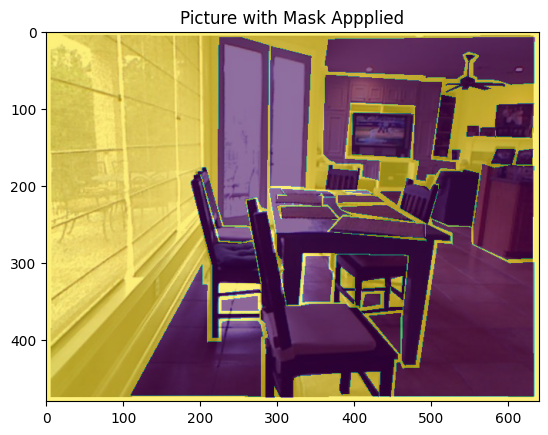

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [ ]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        mask = deformat_mask(mask)
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, transform=t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, transform=t_val, patch=False)

#dataloader
batch_size= 2


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Model

In [ ]:
model = smp.Unet('efficientnet-b3', encoder_weights='imagenet', classes=14, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16], decoder_attention_type="scse")

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
# model = torch.load('/content/drive/MyDrive/resnet50_nyu_best.pt')

# Training

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=14):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            # loss = SegLossFn(output, mask)

            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    # loss = SegLossFn(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Efficient-b3_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    # break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
class_weights = []
for i in range(len(pixel_per_class)):
  class_weight = 1-(pixel_per_class[i] /  np.sum(pixel_per_class))
  class_weights.append(class_weight)
print(class_weights)

[0.9623888410988267, 0.9941121713062199, 0.9863075831077016, 0.9667976976158243, 0.90124475582412, 0.8552395545417795, 0.8739797477859883, 0.9787880401060469, 0.9752779912661703, 0.9685553720338824, 0.9952111155375677, 0.7656515851806934, 0.9501823827419901, 0.8262631618531889]


In [ ]:
class_weights = torch.tensor(class_weights,dtype=torch.float)

In [ ]:
class_weights= class_weights.cuda()

In [ ]:
class_weights

tensor([0.9624, 0.9941, 0.9863, 0.9668, 0.9012, 0.8552, 0.8740, 0.9788, 0.9753,
        0.9686, 0.9952, 0.7657, 0.9502, 0.8263], device='cuda:0')

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss, TverskyLoss
from segmentation_models_pytorch.losses.constants import MULTICLASS_MODE

In [ ]:
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F


class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.

    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 2.,
                 beta: float = 0.5,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.

        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)
        self.dice_loss = DiceLoss(mode='multiclass')
    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v!r}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        x_org = x
        y_org = y
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        dice = self.dice_loss(x_org, y_org)
        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        focal = focal_term * ce

        loss = self.beta*focal + self.beta*dice
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
               gamma: float = 2.,
               beta: float = 0.5,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLoss:
    """Factory function for FocalLoss.

    Args:
        alpha (Sequence, optional): Weights for each class. Will be converted
            to a Tensor if not None. Defaults to None.
        gamma (float, optional): A constant, as described in the paper.
            Defaults to 0.
        reduction (str, optional): 'mean', 'sum' or 'none'.
            Defaults to 'mean'.
        ignore_index (int, optional): class label to ignore.
            Defaults to -100.
        device (str, optional): Device to move alpha to. Defaults to 'cpu'.
        dtype (torch.dtype, optional): dtype to cast alpha to.
            Defaults to torch.float32.

    Returns:
        A FocalLoss object
    """
    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        beta=beta,
        reduction=reduction,
        ignore_index=ignore_index)
    return fl

In [ ]:
# criterion = focal_loss(alpha=class_weights, device=device)
criterion = focal_loss(alpha=class_weights, device=device)

# criterion = nn.CrossEntropyLoss(reduction='mean')

In [ ]:
max_lr = 1e-3
epoch = 20
weight_decay = 1e-4

# criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.799 
Epoch:1/20.. Train Loss: 1.022.. Val Loss: 0.799.. Train mIoU:0.144.. Val mIoU: 0.236.. Train Acc:0.364.. Val Acc:0.517.. Time: 3.99m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.799 >> 0.638 
Epoch:2/20.. Train Loss: 0.766.. Val Loss: 0.638.. Train mIoU:0.262.. Val mIoU: 0.328.. Train Acc:0.505.. Val Acc:0.584.. Time: 3.82m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.638 >> 0.607 
Epoch:3/20.. Train Loss: 0.684.. Val Loss: 0.607.. Train mIoU:0.317.. Val mIoU: 0.360.. Train Acc:0.531.. Val Acc:0.580.. Time: 3.83m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.607 >> 0.585 
saving model...
Epoch:4/20.. Train Loss: 0.662.. Val Loss: 0.585.. Train mIoU:0.330.. Val mIoU: 0.367.. Train Acc:0.536.. Val Acc:0.588.. Time: 3.82m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/20.. Train Loss: 0.638.. Val Loss: 0.623.. Train mIoU:0.346.. Val mIoU: 0.353.. Train Acc:0.547.. Val Acc:0.574.. Time: 3.82m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.623 >> 0.548 
Epoch:6/20.. Train Loss: 0.626.. Val Loss: 0.548.. Train mIoU:0.354.. Val mIoU: 0.377.. Train Acc:0.554.. Val Acc:0.618.. Time: 3.82m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/20.. Train Loss: 0.602.. Val Loss: 0.575.. Train mIoU:0.372.. Val mIoU: 0.360.. Train Acc:0.570.. Val Acc:0.595.. Time: 3.83m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.575 >> 0.533 
Epoch:8/20.. Train Loss: 0.580.. Val Loss: 0.533.. Train mIoU:0.383.. Val mIoU: 0.408.. Train Acc:0.581.. Val Acc:0.633.. Time: 3.81m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.533 >> 0.530 
Epoch:9/20.. Train Loss: 0.552.. Val Loss: 0.530.. Train mIoU:0.402.. Val mIoU: 0.404.. Train Acc:0.601.. Val Acc:0.622.. Time: 3.82m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/20.. Train Loss: 0.529.. Val Loss: 0.552.. Train mIoU:0.424.. Val mIoU: 0.400.. Train Acc:0.617.. Val Acc:0.623.. Time: 3.85m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.552 >> 0.504 
Epoch:11/20.. Train Loss: 0.497.. Val Loss: 0.504.. Train mIoU:0.442.. Val mIoU: 0.419.. Train Acc:0.634.. Val Acc:0.645.. Time: 3.83m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.504 >> 0.480 
saving model...
Epoch:12/20.. Train Loss: 0.468.. Val Loss: 0.480.. Train mIoU:0.464.. Val mIoU: 0.440.. Train Acc:0.656.. Val Acc:0.670.. Time: 3.83m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.480 >> 0.457 
Epoch:13/20.. Train Loss: 0.441.. Val Loss: 0.457.. Train mIoU:0.484.. Val mIoU: 0.455.. Train Acc:0.671.. Val Acc:0.678.. Time: 3.85m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.457 >> 0.451 
Epoch:14/20.. Train Loss: 0.408.. Val Loss: 0.451.. Train mIoU:0.505.. Val mIoU: 0.461.. Train Acc:0.692.. Val Acc:0.680.. Time: 3.83m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.451 >> 0.433 
Epoch:15/20.. Train Loss: 0.383.. Val Loss: 0.433.. Train mIoU:0.528.. Val mIoU: 0.475.. Train Acc:0.710.. Val Acc:0.696.. Time: 3.82m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.433 >> 0.420 
Epoch:16/20.. Train Loss: 0.356.. Val Loss: 0.420.. Train mIoU:0.549.. Val mIoU: 0.486.. Train Acc:0.730.. Val Acc:0.694.. Time: 3.84m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.420 >> 0.402 
saving model...
Epoch:17/20.. Train Loss: 0.335.. Val Loss: 0.402.. Train mIoU:0.567.. Val mIoU: 0.507.. Train Acc:0.745.. Val Acc:0.711.. Time: 3.83m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:18/20.. Train Loss: 0.321.. Val Loss: 0.407.. Train mIoU:0.580.. Val mIoU: 0.498.. Train Acc:0.755.. Val Acc:0.711.. Time: 3.84m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.407 >> 0.405 
Epoch:19/20.. Train Loss: 0.310.. Val Loss: 0.405.. Train mIoU:0.590.. Val mIoU: 0.495.. Train Acc:0.762.. Val Acc:0.716.. Time: 3.84m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:20/20.. Train Loss: 0.306.. Val Loss: 0.408.. Train mIoU:0.595.. Val mIoU: 0.499.. Train Acc:0.765.. Val Acc:0.713.. Time: 3.85m
Total time: 76.76 m


In [ ]:
torch.save(model, '/content/drive/MyDrive/scse_concate.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

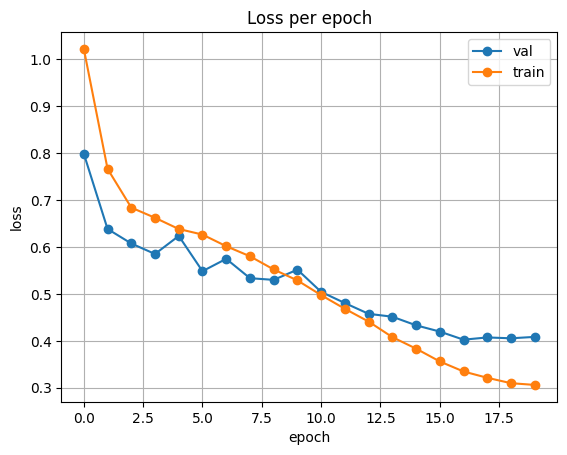

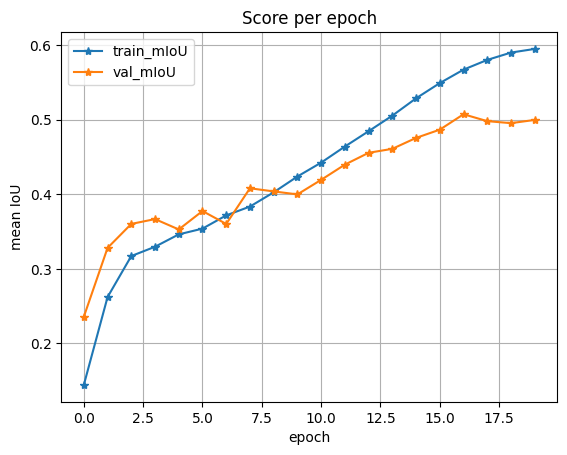

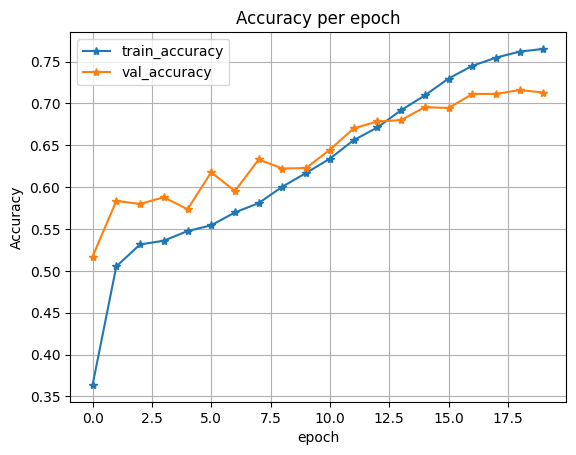

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [ ]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


# t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=None)

## Result

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/145 [00:00<?, ?it/s]

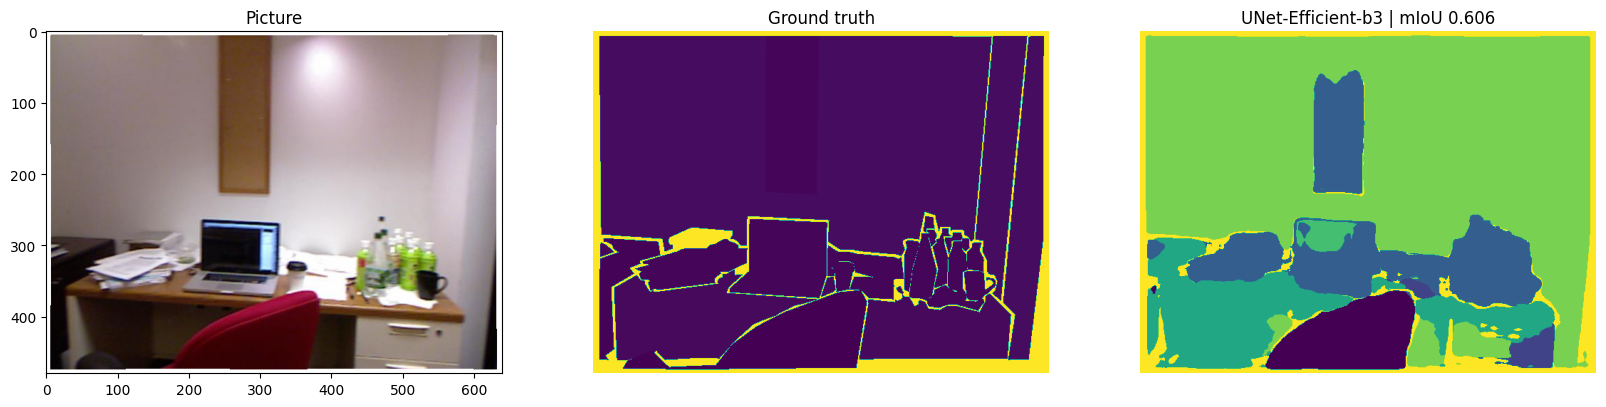

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-Efficient-b3 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

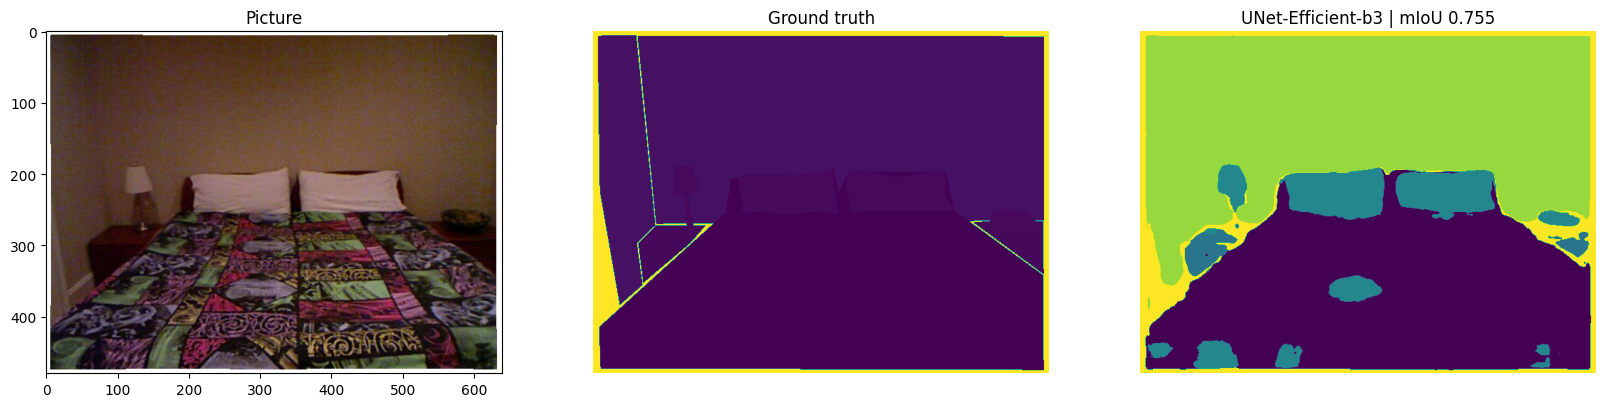

In [ ]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-Efficient-b3 | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

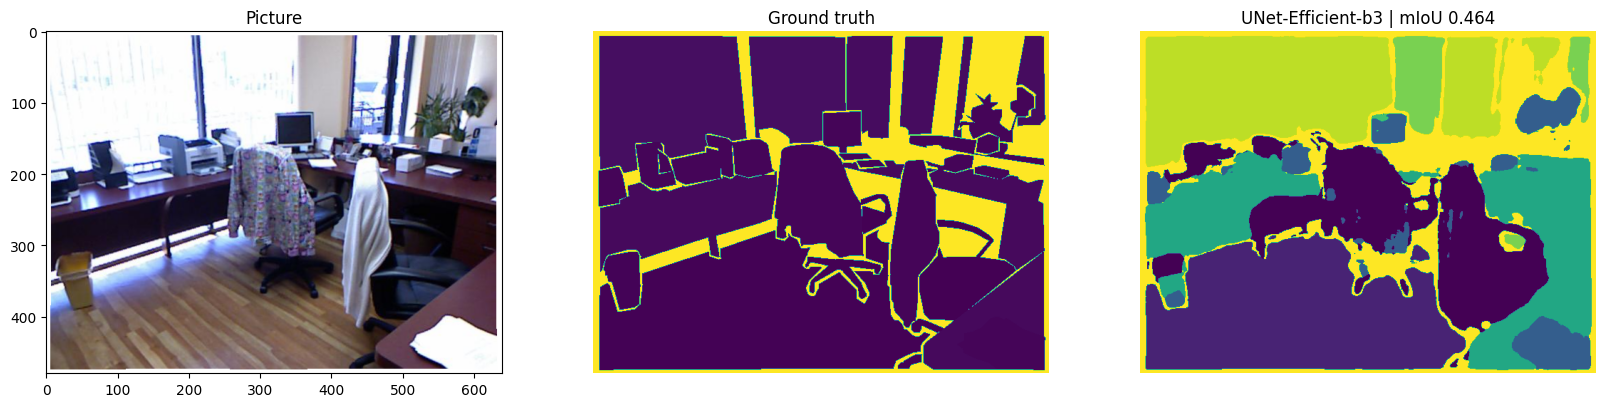

In [ ]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-Efficient-b3 | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.5421533204984565


In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.6186610317887932


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

In [ ]:
pytorch_total_params

16224730

In [ ]:
def mean_acc(pred_mask, mask, smooth=1e-10, n_classes=14):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        acc_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                acc_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = true_label.sum().float().item()

                acc = (intersect + smooth) / (union +smooth)
                acc_per_class.append(acc)
        return np.nanmean(acc_per_class)


In [ ]:
def predict_image_mask_mean_acc(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        m_acc = mean_acc(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, m_acc

In [ ]:
def mean_acc_classes(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_mean_acc(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
m_acc_score = mean_acc_classes(model, test_set)

  0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
print(np.mean(m_acc_score))

0.6713312215754913


In [ ]:
def fw_iou(pred_mask, mask, smooth=1e-10):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        class_num = 14
        iou_per_class = []
        # Tính f.w. IoU cho từng lớp hoặc đối tượng
        for clas in range(0, class_num):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(0)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                weighted = intersect * true_label.sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (weighted + smooth) / (union +smooth)
                iou_per_class.append(iou)
        total = 0
        for item in iou_per_class:
            total += item
        f_w_iou = total / float(mask.numel())
    return f_w_iou

In [ ]:
def predict_image_mask_fw_iou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        fw_iou_pred = fw_iou(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, fw_iou_pred

In [ ]:
def fw_iou_classes(model, test_set):
    fw_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_fw_iou(model, img, mask)
        fw_iou.append(acc)
    return fw_iou

In [ ]:
fw_iou_score = fw_iou_classes(model, test_set)

  0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
print(np.mean(fw_iou_score))

0.5307751721617087


In [ ]:
def dice_coef_multilabel(y_pred, y_true, num_class=14, smooth=1):
    with torch.no_grad():
        pred_mask = F.softmax(y_pred, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = y_true.contiguous().view(-1)

        dice_per_class = []
        # Tính f.w. IoU cho từng lớp hoặc đối tượng
        for clas in range(0, num_class):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                dice_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()

                union = torch.logical_or(true_class, true_label).sum().float().item()

                dice = (2 * intersect + smooth) / (union + intersect + smooth)
                dice_per_class.append(dice)
    return dice_per_class

In [ ]:
def predict_image_mask_dice_score(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        dice_score_pred = dice_coef_multilabel(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, dice_score_pred

In [ ]:
def dice_score_classes(model, test_set):
    dice_score = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, dice = predict_image_mask_dice_score(model, img, mask)
        dice_score.append(dice)
    return dice_score

In [ ]:
dice_score_per_class = dice_score_classes(model, test_set)

  0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
dice_score_classes = np.nanmean(dice_score_per_class, axis=0)

<ipython-input-67-a9b7a5ab5bbd>:1: RuntimeWarning: Mean of empty slice
  dice_score_classes = np.nanmean(dice_score_per_class, axis=0)


In [ ]:
print(dice_score_classes)


[0.70262989 0.40841597 0.68526523 0.55170795 0.8499216  0.50099732
 0.49181134 0.59445866 0.61505204 0.44868645 0.80193389 0.79574132
 0.74957824        nan]


In [ ]:
print(np.nanmean(dice_score_classes))

0.6304769158223044


In [ ]:
   class_index = \
   {
         0: [(64, 128, 64),  'Bed'],
         1: [(192, 0, 64),  'Books'],
         2: [(0, 128, 192),  'Ceiling'],
         3: [(0, 128, 128),   'Chair'],
         4: [(128, 64, 0),    'Floor'],
         5: [(64, 64, 128),   'Furniture'],
         6: [(64, 64, 192),   'Objects'],
         7: [(192, 128, 64), 'Picture'],
         8: [(192, 192, 128),'Sofa'],
         9: [(128, 192, 128),  'Table'],
        10: [(128, 0, 192),  'TV'],
        11: [(192, 0, 192),   'Wall'],
        12: [(128, 128, 64), 'Window'],
        13: [(0, 0, 0),  'Unlabeled'],

    }

In [ ]:
# Function to convert a single channel mask representation to an RGB mask.
def class_to_rgb(mask_class, class_index):

    # Create RGB channels
    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)

    # Populate RGB color channels based on the color assigned to each class.
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]

    seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)

    return seg_map_rgb

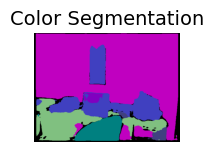

In [ ]:
pred_mask_rgb = class_to_rgb(pred_mask, class_index)

plt.subplot(1,3,1)
plt.title('Color Segmentation', fontsize=14)
plt.imshow(pred_mask_rgb, cmap='gray')
plt.axis('off');

In [ ]:
def plot_color_legend(class_index):

    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [val[1] for val in class_index.values()]

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(15, 3))
    plt.subplots_adjust(wspace = 0.1, hspace=0.5)

    # Display color legend.
    for i, axis in enumerate(ax.flat):

        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize = 8)
        axis.axis('off')

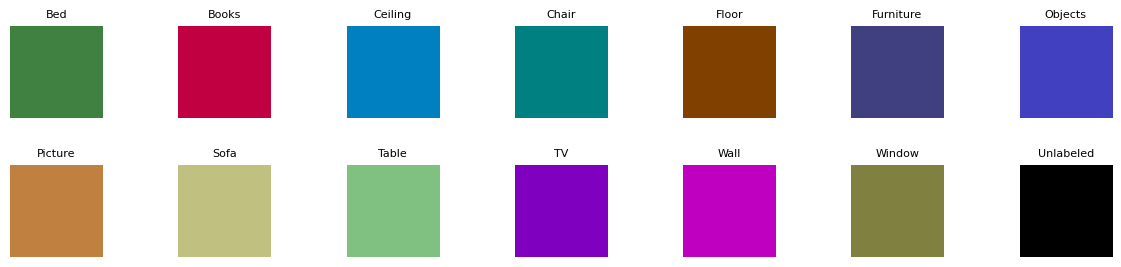

In [ ]:
plot_color_legend(class_index)